In [ ]:
!pip install tensorflow-gpu

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


Importing Necessary Libraries

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.activations import relu, sigmoid, tanh,elu
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, BatchNormalization, Activation, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, RMSprop, SGD, Adagrad
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping
from sklearn.model_selection import GridSearchCV
from keras import regularizers
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import random
import os
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, classification_report


Loading and Visualizing the Datasets


Shape of training dataset: (112800, 28, 28)
Shape of testing dataset: (18800, 28, 28)
## This indicates the height and width of both the datasets are (28, 28) respectively
The number of samples in training dataset is 112800
The number of samples in testing dataset is 18800


Visualizing 32 random training data


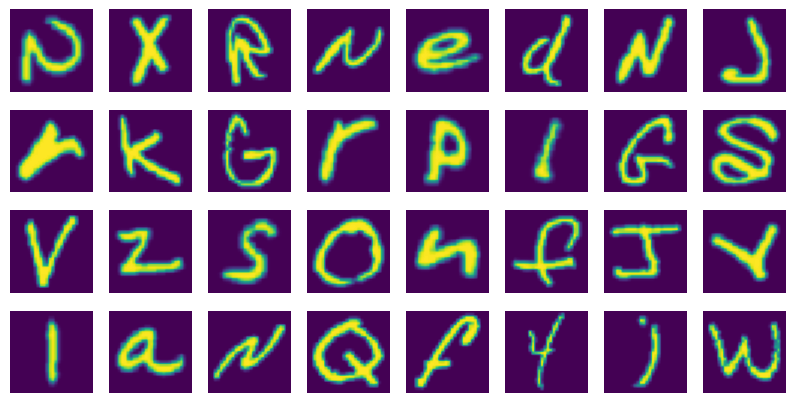



Visualizing a random data with the class label


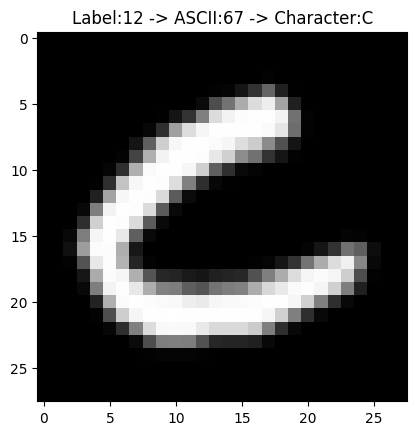

In [3]:
random.seed(201668539)
np.random.seed(201675270)
# 2. LOADING THE BALANCED EMNIST DATASET
training_data = datasets.EMNIST(root= "./data", train=True, download= True, transform=ToTensor(), split = 'balanced')
train_X = training_data.data
train_y = training_data.targets

# 3. SPLITTING INTO TRAINING DATASET AND TESTING DATASET
testing_data = datasets.EMNIST(root= "./data", train=False, download= True, transform=ToTensor(), split = 'balanced')
test_X = testing_data.data
test_y = testing_data.targets

# 4. I. PRINTING THE NUMBER OF TRAINING AND TESTING SAMPLES  
print("Shape of training dataset:", tuple(training_data.data.shape))
print("Shape of testing dataset:", tuple(testing_data.data.shape))
print("## This indicates the height and width of both the datasets are {} respectively".format(tuple(training_data.data.shape[1:])))
print("The number of samples in training dataset is", training_data.data.shape[0])
print("The number of samples in testing dataset is", testing_data.data.shape[0])

# 4. II. PLOTTING SOME FIGURES TO VISUALIZE FEW SAMPLES
# Selecting random 32 trained training set images
figure = plt.figure(figsize=(10, 5))
random_indices = np.random.choice(len(training_data), 32, replace = False)
print("\n\nVisualizing 32 random training data")
for i in range(32):
    figure.add_subplot(4, 8, i+1)
    plt.axis("off")
    image_after_transpose = training_data[random_indices[i]][0].T
    plt.imshow(image_after_transpose.squeeze())
plt.show()

# Reading the mapping file and storing it in a dictionary
# Getting the ASCII value for the class label from the dictionary and displaying the character of the ASCII
with open('emnist-balanced-mapping.txt', 'r') as f:
    lines = f.readlines()
mapping_dict = {}
for each_line in lines:
    label, ascii = each_line.strip().split(" ")
    mapping_dict.update({int(label) : int(ascii)})

# Visualizing a random image and displaying it with class label 
print("\n\nVisualizing a random data with the class label")
plt.figure()
one_random_data = training_data[random.randint(0,len(training_data)-1)]
transposed_random_data = one_random_data[0].T
plt.imshow(transposed_random_data.squeeze(), cmap = "gray")
plt.title('Label:'+ str(one_random_data[1]) + ' -> ASCII:' + str(mapping_dict[one_random_data[1]]) + ' -> Character:' + chr(mapping_dict[one_random_data[1]]))
plt.show()

MLP Activation Function

In [ ]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
# Load EMNIST data from tensorflow
train_data, test_data = tfds.load("emnist/balanced", split=["train[:80%]", "train[80%:]"], as_supervised=True)

# Preprocessing function for EMNIST data
def to_image(image):
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, size=(28, 28))
    return image

# Change data to image format to EMNIST data
train_data = train_data.map(lambda x, y: (to_image(x), y))
test_data = test_data.map(lambda x, y: (to_image(x), y))


# Exploring activation function
def create_mlp_model_relu():
    model = Sequential([
        Flatten(input_shape=(28,28,1)),
        Dense(256, activation='relu'),
        Dense(256, activation='relu'),
        Dense(256, activation='relu'),
        Dense(256, activation='relu'),
        Dense(64, activation='softmax')
    ])
    return model

def create_mlp_model_tanh():
    model = Sequential([
        Flatten(input_shape=(28,28,1)),
        Dense(256, activation='tanh'),
        Dense(256, activation='tanh'),
        Dense(256, activation='tanh'),
        Dense(256, activation='tanh'),
        Dense(64, activation='softmax')
    ])
    return model
  
def create_mlp_model_sigmoid():
    model = Sequential([
        Flatten(input_shape=(28,28,1)),
        Dense(256, activation='sigmoid'),
        Dense(256, activation='sigmoid'),
        Dense(256, activation='sigmoid'),
        Dense(256, activation='sigmoid'),
        Dense(64, activation='softmax')
    ])
    return model

# Constant learning rate
def lr_schedule(epoch):
    return 0.001

print("Setting the batch size to 128, so each batch will be of size 0.8*112800/128 = 705")
print("\nExploring Activation function\n")

# Compile MLP model for each activation function
mlp_model_relu = create_mlp_model_relu()
mlp_model_tanh = create_mlp_model_tanh()
mlp_model_sigmoid = create_mlp_model_sigmoid()

mlp_model_relu.compile(optimizer=Adam(learning_rate = 0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
mlp_model_tanh.compile(optimizer=Adam(learning_rate = 0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
mlp_model_sigmoid.compile(optimizer=Adam(learning_rate = 0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Fit for the models
print("\nFitting Tanh model\n")
mlp_history_tanh = mlp_model_tanh.fit(train_data.batch(128), epochs=10, validation_data=test_data.batch(128), callbacks=[LearningRateScheduler(lr_schedule)])
print("\nFitting Relu model\n")
mlp_history_relu = mlp_model_relu.fit(train_data.batch(128), epochs=10, validation_data=test_data.batch(128), callbacks=[LearningRateScheduler(lr_schedule)])
print("\nFitting Sigmoid model\n")
mlp_history_sigmoid = mlp_model_sigmoid.fit(train_data.batch(128), epochs=10, validation_data=test_data.batch(128), callbacks=[LearningRateScheduler(lr_schedule)])

# Plot MLP validation accuracy to compare the activation function
plt.plot(range(1,11), mlp_history_relu.history['val_accuracy'], label='Relu')
plt.plot(range(1,11), mlp_history_tanh.history['val_accuracy'], label='Tanh')
plt.plot(range(1,11), mlp_history_sigmoid.history['val_accuracy'], label='Sigmoid')
plt.title('Explore activation function by Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()  

print("\n\nRELU IS BETTER PERFORMING MODEL\n\n")

# Plot MLP accuracy of train and validation data
plt.plot(range(1,11), mlp_history_relu.history['accuracy'], label='train')
plt.plot(range(1,11), mlp_history_relu.history['val_accuracy'], label='validation')
plt.title('MLP Relu Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Plot MLP loss of train and validation data
plt.plot(range(1,11), mlp_history_relu.history['loss'], label='train')
plt.plot(range(1,11), mlp_history_relu.history['val_loss'], label='validation')
plt.title('MLP Relu Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

Hidden Layers(MLP)

In [ ]:
# Exploring hidden layers
def create_mlp_model_5_layer():
    model = Sequential([
        Flatten(input_shape=(28,28,1)),
        Dense(256, activation='relu'),
        Dense(256, activation='relu'),
        Dense(256, activation='relu'),
        Dense(256, activation='relu'),
        Dense(256, activation='relu'),
        Dense(64, activation='softmax')
    ])
    return model

def create_mlp_model_4_layer():
    model = Sequential([
        Flatten(input_shape=(28,28,1)),
        Dense(256, activation='relu'),
        Dense(256, activation='relu'),
        Dense(256, activation='relu'),
        Dense(256, activation='relu'),
        Dense(64, activation='softmax')
    ])
    return model

def create_mlp_model_3_layer():
    model = Sequential([
        Flatten(input_shape=(28,28,1)),
        Dense(256, activation='relu'),
        Dense(256, activation='relu'),
        Dense(256, activation='relu'),
        Dense(64, activation='softmax')
    ])
    return model

# Compile MLP model for each number of hidden layers
mlp_model_4_layer = create_mlp_model_4_layer()
mlp_model_5_layer = create_mlp_model_5_layer()
mlp_model_3_layer = create_mlp_model_3_layer()

mlp_model_4_layer.compile(optimizer=Adam(learning_rate = 0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
mlp_model_5_layer.compile(optimizer=Adam(learning_rate = 0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
mlp_model_3_layer.compile(optimizer=Adam(learning_rate = 0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Fit the models
print("\nFitting 4 layer model\n")
mlp_history_4_layer = mlp_model_4_layer.fit(train_data.batch(128), epochs=10, validation_data=test_data.batch(128), callbacks=[LearningRateScheduler(lr_schedule)])
print("\nFitting 5 layer model\n")
mlp_history_5_layer = mlp_model_5_layer.fit(train_data.batch(128), epochs=10, validation_data=test_data.batch(128), callbacks=[LearningRateScheduler(lr_schedule)])
print("\nFitting 3 layer model\n")
mlp_history_3_layer = mlp_model_3_layer.fit(train_data.batch(128), epochs=10, validation_data=test_data.batch(128), callbacks=[LearningRateScheduler(lr_schedule)])

# Plot MLP validation accuracy to compare hidden layers
plt.plot(range(1,11), mlp_history_4_layer.history['val_accuracy'], label='4 layer')
plt.plot(range(1,11), mlp_history_5_layer.history['val_accuracy'], label='5 layer')
plt.plot(range(1,11), mlp_history_3_layer.history['val_accuracy'], label='3 layer')
plt.title('Explore hidden layers by Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()  

print("\n\nMODEL IS BETTER PERFORMING WHEN HIDDEN LAYER IS 4\n\n")
# Plot MLP accuracy of train and validation data
plt.plot(range(1,11), mlp_history_4_layer.history['accuracy'], label='train')
plt.plot(range(1,11), mlp_history_4_layer.history['val_accuracy'], label='validation')
plt.title('MLP 4 layers Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Plot MLP loss of train and validation data
plt.plot(range(1,11), mlp_history_4_layer.history['loss'], label='train')
plt.plot(range(1,11), mlp_history_4_layer.history['val_loss'], label='validation')
plt.title('MLP 4 layers Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

Number of neurons(MLP)

In [ ]:
# Exploring number of neurons in hidden layer
def create_mlp_model_neuron_1():
    model = Sequential([
        Flatten(input_shape=(28,28,1)),
        Dense(256, activation='relu'),
        Dense(256, activation='relu'),
        Dense(256, activation='relu'),
        Dense(256, activation='relu'),
        Dense(64, activation='softmax')
    ])
    return model

def create_mlp_model_neuron_2():
    model = Sequential([
        Flatten(input_shape=(28,28,1)),
        Dense(256, activation='relu'),
        Dense(128, activation='relu'),
        Dense(128, activation='relu'),
        Dense(128, activation='relu'),
        Dense(64, activation='softmax')
    ])
    return model

def create_mlp_model_neuron_3():
    model = Sequential([
        Flatten(input_shape=(28,28,1)),
        Dense(256, activation='relu'),
        Dense(256, activation='relu'),
        Dense(128, activation='relu'),
        Dense(128, activation='relu'),
        Dense(64, activation='softmax')
    ])
    return model

# Compile MLP model for each number of hidden layers
mlp_model_neuron_1 = create_mlp_model_neuron_1()
mlp_model_neuron_2 = create_mlp_model_neuron_2()
mlp_model_neuron_3 = create_mlp_model_neuron_3()

mlp_model_neuron_1.compile(optimizer=Adam(learning_rate = 0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
mlp_model_neuron_2.compile(optimizer=Adam(learning_rate = 0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
mlp_model_neuron_3.compile(optimizer=Adam(learning_rate = 0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Fit the models
print("\nFitting number of neurons - 1 \n")
mlp_history_neuron_1 = mlp_model_neuron_1.fit(train_data.batch(128), epochs=10, validation_data=test_data.batch(128), callbacks=[LearningRateScheduler(lr_schedule)])
print("\nFitting number of neurons - 2\n")
mlp_history_neuron_2 = mlp_model_neuron_2.fit(train_data.batch(128), epochs=10, validation_data=test_data.batch(128), callbacks=[LearningRateScheduler(lr_schedule)])
print("\nFitting number of neurons - 3\n")
mlp_history_neuron_3 = mlp_model_neuron_3.fit(train_data.batch(128), epochs=10, validation_data=test_data.batch(128), callbacks=[LearningRateScheduler(lr_schedule)])

# Plot MLP validation accuracy to compare number of neurons
plt.plot(range(1,11), mlp_history_neuron_1.history['val_accuracy'], label='Neuron count - 1')
plt.plot(range(1,11), mlp_history_neuron_2.history['val_accuracy'], label='Neuron count - 2')
plt.plot(range(1,11), mlp_history_neuron_3.history['val_accuracy'], label='Neuron count - 3')
plt.title('Explore number of neurons in hidden layers by Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()  

print("\n\nMODEL IS BETTER PERFORMING WHEN NUMBER OF NEURONS ARE 256, 256, 256, 256\n\n")

# Plot MLP accuracy of train and validation data
plt.plot(range(1,11), mlp_history_neuron_1.history['accuracy'], label='train')
plt.plot(range(1,11), mlp_history_neuron_1.history['val_accuracy'], label='validation')
plt.title('MLP - NEURONS 256, 256, 256, 256 Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Plot MLP loss of train and validation data
plt.plot(range(1,11), mlp_history_neuron_1.history['loss'], label='train')
plt.plot(range(1,11), mlp_history_neuron_1.history['val_loss'], label='validation')
plt.title('MLP - NEURONS 256, 256, 256, 256 Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()


MLP Optimizers(MLP)

In [ ]:
# Explore types of Optimizers
# Compile MLP model for each number of hidden layers
mlp_model_Adam = create_mlp_model_relu()
mlp_model_SGD = create_mlp_model_relu() 
mlp_model_RMSprop = create_mlp_model_relu()
mlp_model_Adagrad = create_mlp_model_relu()

mlp_model_Adam.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
mlp_model_SGD.compile(optimizer=SGD(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
mlp_model_RMSprop.compile(optimizer=RMSprop(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
mlp_model_Adagrad.compile(optimizer=Adagrad(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Fit the models
print("\nFitting Adam model\n")
mlp_history_Adam = mlp_model_Adam.fit(train_data.batch(128), epochs=10, validation_data=test_data.batch(128), callbacks=[LearningRateScheduler(lr_schedule)])
print("\nFitting SGD model\n")
mlp_history_SGD = mlp_model_SGD.fit(train_data.batch(128), epochs=10, validation_data=test_data.batch(128), callbacks=[LearningRateScheduler(lr_schedule)])
print("\nFitting Adagrad model\n")
mlp_history_Adagrad = mlp_model_Adagrad.fit(train_data.batch(128), epochs=10, validation_data=test_data.batch(128), callbacks=[LearningRateScheduler(lr_schedule)])
print("\nFitting RMSprop model\n")
mlp_history_RMSprop = mlp_model_RMSprop.fit(train_data.batch(128), epochs=10, validation_data=test_data.batch(128), callbacks=[LearningRateScheduler(lr_schedule)])

# Plot MLP accuracy to compare optimiers
plt.plot(range(1,11), mlp_history_Adam.history['val_accuracy'], label='Adam')
plt.plot(range(1,11), mlp_history_SGD.history['val_accuracy'], label='SGD')
plt.plot(range(1,11), mlp_history_Adagrad.history['val_accuracy'], label='Adagrad')
plt.plot(range(1,11), mlp_history_RMSprop.history['val_accuracy'], label='RMSprop')
plt.title('Explore Optimizer with Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Plot MLP accuracy of train and test data
plt.plot(range(1,11), mlp_history_Adam.history['accuracy'], label='train')
plt.plot(range(1,11), mlp_history_Adam.history['val_accuracy'], label='validation')
plt.title('MLP ADAM model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Plot MLP loss of train and test data
plt.plot(range(1,11), mlp_history_Adam.history['loss'], label='train')
plt.plot(range(1,11), mlp_history_Adam.history['val_loss'], label='validation')
plt.title('MLP ADAM Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

Learning rate schedulers(MLP)

In [ ]:
mlp_model_constant = create_mlp_model_relu()
mlp_model_step_decay = create_mlp_model_relu()

# Define learning rate schedule
def lr_schedule_constant(epoch):
    learning_rate = 0.001  # set a constant learning rate
    return learning_rate

def step_decay(epoch):
    initial_learning_rate = 0.001
    if epoch > 5:
       initial_learning_rate *= tf.math.exp(-0.1 * (epoch - 5))
    return initial_learning_rate

# Compile MLP model
mlp_model_step_decay.compile(optimizer = Adam(learning_rate = 0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
mlp_model_constant.compile(optimizer = Adam(learning_rate = 0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Fit MLP model
mlp_history_step_decay = mlp_model_step_decay.fit(train_data.batch(128), epochs=10, validation_data=test_data.batch(128), callbacks=[LearningRateScheduler(step_decay)])
mlp_history_constant = mlp_model_constant.fit(train_data.batch(128), epochs=10, validation_data=test_data.batch(128), callbacks=[LearningRateScheduler(lr_schedule_constant)])

# Plot MLP accuracy to explore types of learning rate schedulers
plt.plot(mlp_history_constant.history['val_accuracy'], label='constant')
plt.plot(mlp_history_step_decay.history['val_accuracy'], label='step decay')
plt.title('Explore learning rate scheduler')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

print("\n\nMODEL IS BETTER PERFORMING WHEN STEP DECAY LEARNING RATE SCHEDULER IS USED\n\n")

# Plot MLP accuracy of train and validation data
plt.plot(mlp_history_step_decay.history['accuracy'], label='train')
plt.plot(mlp_history_step_decay.history['val_accuracy'], label='validation')
plt.title('MLP Step Decay model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()
# Plot MLP loss of train and validation data
plt.plot(mlp_history_step_decay.history['loss'], label='train')
plt.plot(mlp_history_step_decay.history['val_loss'], label='validation')
plt.title('MLP Step Decay Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()


Batch Normalization(MLP)

In [ ]:
# Explore batch normalization
def create_mlp_no_batch():
  model = Sequential([
        Flatten(input_shape=(28,28,1)),
        Dense(256, activation='relu'),
        Dense(256, activation='relu'),
        Dense(256, activation='relu'),
        Dense(64, activation='softmax')
    ])
  return model
  
def create_mlp_with_batch():
  model = Sequential([
        Flatten(input_shape=(28,28,1)),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dense(64, activation='softmax')
    ])
  return model

# Compile the models
mlp_model_without_batch = create_mlp_no_batch()
mlp_model_with_batch = create_mlp_with_batch()
mlp_model_without_batch.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
mlp_model_with_batch.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Fit the models
mlp_history_with_batch = mlp_model_constant.fit(train_data.batch(128), epochs=10, validation_data=test_data.batch(128), callbacks=[LearningRateScheduler(step_decay)])
mlp_history_without_batch = mlp_model_without_batch.fit(train_data.batch(128), epochs=10, validation_data=test_data.batch(128), callbacks=[LearningRateScheduler(step_decay)])

print("\n\nMODEL IS BETTER PERFORMING WITHOUT BATCH NORMALIZATION\n\n")

# Plot MLP accuracy to compare batch normalization
plt.plot(mlp_history_without_batch.history['val_accuracy'], label='without batch')
plt.plot(mlp_history_with_batch.history['val_accuracy'], label='with batch')
plt.title('Explore batch normalization model')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Plot MLP accuracy of train and validation data
plt.plot(mlp_history_step_decay.history['accuracy'], label='train')
plt.plot(mlp_history_step_decay.history['val_accuracy'], label='validation')
plt.title('MLP without batch model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()
# Plot MLP loss of train and validation data
plt.plot(mlp_history_step_decay.history['loss'], label='train')
plt.plot(mlp_history_step_decay.history['val_loss'], label='validation')
plt.title('MLP without batch model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

With L1 and L2 regularizers (MLP)

In [ ]:
# Explore L1 and L2 regularization
def create_mlp_model_l1():
    model = Sequential([
        Flatten(input_shape=(28,28,1)),
        Dense(256, activation='relu', kernel_regularizer=regularizers.l1(0.001), bias_regularizer=regularizers.l1(0.001)),
        Dense(256, activation='relu', kernel_regularizer=regularizers.l1(0.001), bias_regularizer=regularizers.l1(0.001)),
        Dense(256, activation='relu', kernel_regularizer=regularizers.l1(0.001), bias_regularizer=regularizers.l1(0.001)),
        Dense(64, activation='softmax')
    ])
    return model

def create_mlp_model_l2():
    model = Sequential([
        Flatten(input_shape=(28,28,1)),
        Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001), bias_regularizer=regularizers.l2(0.001)),
        Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001), bias_regularizer=regularizers.l2(0.001)),
        Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001), bias_regularizer=regularizers.l2(0.001)),
        Dense(64, activation='softmax')
    ])
    return model

def create_mlp_model_no_l1l2():
    model = Sequential([
        Flatten(input_shape=(28,28,1)),
        Dense(256, activation='relu'),
        Dense(256, activation='relu'),
        Dense(256, activation='relu'),
        Dense(64, activation='softmax')
    ])
    return model

# Compile MLP model
mlp_model_l1 = create_mlp_model_l1()
mlp_model_l2 = create_mlp_model_l1()
mlp_model_no_l1l2 = create_mlp_model_l1()

mlp_model_l1.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
mlp_model_l2.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
mlp_model_no_l1l2.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train MLP model
mlp_history_l1 = mlp_model_l1.fit(train_data.batch(128), epochs=10, validation_data=test_data.batch(128),callbacks=[LearningRateScheduler(step_decay)])
mlp_history_l2 = mlp_model_l2.fit(train_data.batch(128), epochs=10, validation_data=test_data.batch(128),callbacks=[LearningRateScheduler(step_decay)])
mlp_history_no_l1l2 = mlp_model_no_l1l2.fit(train_data.batch(128), epochs=10, validation_data=test_data.batch(128),callbacks=[LearningRateScheduler(step_decay)])

print("\n\nMODEL IS BETTER PERFORMING WITH L2 REGULARIZATION\n\n")

# Plot MLP accuracy
plt.plot(mlp_history_l1.history['val_accuracy'], label='L1')
plt.plot(mlp_history_l2.history['val_accuracy'], label='L2')
plt.plot(mlp_history_no_l1l2.history['val_accuracy'], label='without L1 and L2')
plt.title('Explore regularizations')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Plot MLP accuracy of train and validation data
plt.plot(mlp_history_l2.history['accuracy'], label='train')
plt.plot(mlp_history_l2.history['val_accuracy'], label='validation')
plt.title('MLP with L2 regularization Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Plot MLP loss of train and validation data
plt.plot(mlp_history_l2.history['loss'], label='train')
plt.plot(mlp_history_l2.history['val_loss'], label='validation')
plt.title('MLP with L2 regularization Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

With DropOut MLP

In [ ]:
# Explore dropout

def create_mlp_model_with_dropout():
    model = Sequential([
        Flatten(input_shape=(28,28,1)),
        Dense(256),
        Activation('relu'),
        Dropout(0.2),
        Dense(256),
        Activation('relu'),
        Dropout(0.2),
        Dense(256),
        Activation('relu'), 
        Dropout(0.2),
        Dense(64, activation='softmax')
    ])
    return model

def create_mlp_model_without_dropout():
    model = Sequential([
        Flatten(input_shape=(28,28,1)),
        Dense(256),
        Activation('relu'),
        Dense(256),
        Activation('relu'),
        Dense(256),
        Activation('relu'),
        Dense(64, activation='softmax')
    ])
    return model

# Compile MLP model with dropout
mlp_dropout = create_mlp_model_with_dropout()
mlp_without_dropout = create_mlp_model_without_dropout()
mlp_dropout.compile(optimizer=Adam(learning_rate = 0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
mlp_without_dropout.compile(optimizer=Adam(learning_rate = 0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Fit the model
mlp_history_dropout = mlp_dropout.fit(train_data.batch(128), epochs=10, validation_data=test_data.batch(128), callbacks=[LearningRateScheduler(step_decay)])
mlp_history_without_dropout = mlp_without_dropout.fit(train_data.batch(128), epochs=10, validation_data=test_data.batch(128), callbacks=[LearningRateScheduler(step_decay)])

print("\n\nMODEL IS BETTER PERFORMING WITH DROPOUT\n\n")

# Plot MLP accuracy to compare with and without dropout
plt.plot(mlp_history_dropout.history['val_accuracy'], label='with dropout')
plt.plot(mlp_history_without_dropout.history['val_accuracy'], label='without dropout')
plt.title('Explore dropout)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Plot MLP accuracy with dropout
plt.plot(mlp_history_dropout.history['accuracy'], label='train')
plt.plot(mlp_history_without_dropout.history['val_accuracy'], label='validation')
plt.title('MLP model accuracy with Dropout')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Plot MLP loss
plt.plot(mlp_history_dropout.history['loss'], label='train')
plt.plot(mlp_history_without_dropout.history['val_loss'], label='validation')
plt.title('MLP with dropout model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()



Implementing final model MLP

In [ ]:
def create_best_model():
    model = Sequential([
        Flatten(input_shape=(28,28,1)),
        Dense(256, activation = 'relu', kernel_regularizer=regularizers.l2(0.001), bias_regularizer=regularizers.l2(0.001)),
        Activation('relu'),
        Dropout(0.2),
        Dense(256, activation = 'relu', kernel_regularizer=regularizers.l2(0.001), bias_regularizer=regularizers.l2(0.001)),
        Activation('relu'),
        Dropout(0.2),
        Dense(256, activation = 'relu', kernel_regularizer=regularizers.l2(0.001), bias_regularizer=regularizers.l2(0.001)),
        Activation('relu'), 
        Dropout(0.2),
        Dense(64, activation='softmax')
    ])
    return model
# Define cross-validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

train_data, test_data = tfds.load("emnist/balanced", split=["train", "test"], as_supervised=True)
train_data = train_data.map(lambda x, y: (to_image(x), y))
test_data = test_data.map(lambda x, y: (to_image(x), y))
# Compile the best model
mlp_best_model = create_best_model()
mlp_best_model.compile(optimizer=Adam(learning_rate = 0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
mlp_history_best_model = mlp_best_model.fit(train_data.batch(128), epochs=10, validation_data=test_data.batch(128), callbacks=[LearningRateScheduler(step_decay)])

# Plot MLP accuracy with dropout
plt.plot(mlp_history_best_model.history['accuracy'], label='train')
plt.plot(mlp_history_best_model.history['val_accuracy'], label='test')
plt.title('MLP model accuracy of final model')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()
plt.show()

# Plot MLP loss
plt.plot(mlp_history_best_model.history['loss'], label='train')
plt.plot(mlp_history_best_model.history['val_loss'], label='test')
plt.title('MLP model loss of final model')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

print("\n\n\nThe final model performed with a test accuracy: ", 100*mlp_history_best_model.history['val_accuracy'][-1], "%")
print("The final model performed with a test loss: ", mlp_history_best_model.history['val_loss'][-1])

In [ ]:
# 6. II. Plotting 6 test data and predicting them to match with true labels
predictions = mlp_best_model.predict(test_data.batch(6).take(1))
predicted_labels = np.argmax(predictions, axis=1)

images, true_labels = next(iter(test_data.batch(6)))
true_labels_np = true_labels.numpy()
figure = plt.figure(figsize=(10, 5))
for i in range(6):
    figure.add_subplot(1, 6, i+1)
    plt.axis("off")
    image_after_transpose =   images[i].T.numpy()
    plt.imshow(image_after_transpose.squeeze())
    plt.title("Predicted: "+ chr(mapping_dict[predicted_labels[i]])+ "\nTrue label: "+ chr(mapping_dict[true_labels_np[i]]))
plt.show()

In [ ]:
test_dataset = test_data.batch(100)
prediction = mlp_best_model.predict(test_dataset)
y_pred = np.argmax(prediction, axis=1)

y_true = []
for x, y in test_dataset:
    y_true.append(y.numpy())
y_true = np.concatenate(y_true, axis=0)

cm = confusion_matrix(y_true, y_pred)

plt.imshow(cm, cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.colorbar()
plt.show()

# Get the classification report
class_report = classification_report(y_true, y_pred)

# Print the classification report
print(class_report)

Activation Function

Setting the batch size to 128, so each batch will be of size 0.8*112800/128 = 705

Exploring Activation function


Fitting tanh model

Epoch 1/10
705/705 [==============================] - 26s 21ms/step - loss: 0.9306 - accuracy: 0.7347 - val_loss: 0.5878 - val_accuracy: 0.8151 - lr: 0.0010
Epoch 2/10
705/705 [==============================] - 8s 11ms/step - loss: 0.5125 - accuracy: 0.8341 - val_loss: 0.5108 - val_accuracy: 0.8319 - lr: 0.0010
Epoch 3/10
705/705 [==============================] - 8s 11ms/step - loss: 0.4380 - accuracy: 0.8540 - val_loss: 0.4840 - val_accuracy: 0.8361 - lr: 0.0010
Epoch 4/10
705/705 [==============================] - 7s 10ms/step - loss: 0.3945 - accuracy: 0.8659 - val_loss: 0.4944 - val_accuracy: 0.8345 - lr: 0.0010
Epoch 5/10
705/705 [==============================] - 7s 9ms/step - loss: 0.3600 - accuracy: 0.8758 - val_loss: 0.4833 - val_accuracy: 0.8364 - lr: 0.0010
Epoch 6/10
705/705 [==============================] - 8s 12ms/step - loss: 0.3334 - a

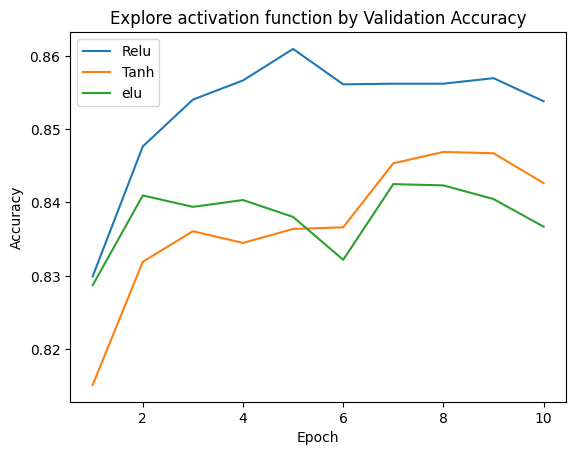



RELU IS BETTER PERFORMING MODEL




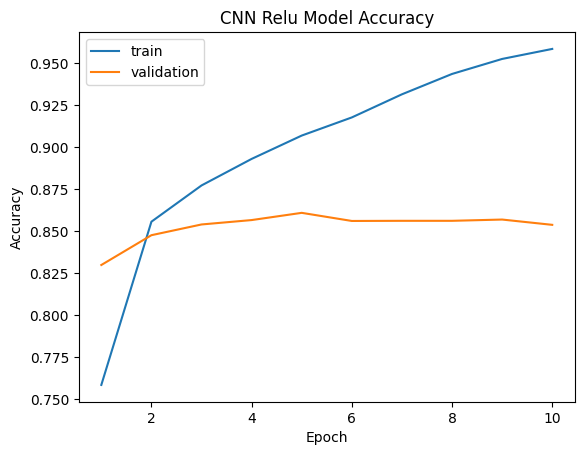

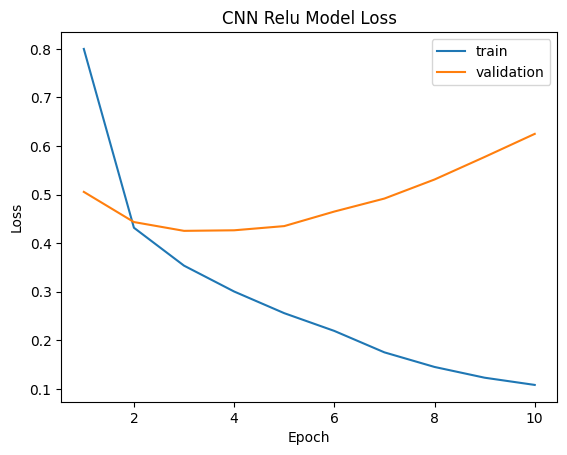

In [5]:
# Exploring activation function
def create_cnn_model_relu():
    model = Sequential([
        Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28,28,1)),
        Conv2D(64, kernel_size=(3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(128, activation='relu'),
        Dense(64, activation='softmax')
    ])
    return model

def create_cnn_model_tanh():
    model = Sequential([
        Conv2D(32, kernel_size=(3, 3), activation='tanh', input_shape=(28,28,1)),
        Conv2D(64, kernel_size=(3, 3), activation='tanh'),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(128, activation='tanh'),
        Dense(64, activation='softmax')
    ])
    return model

def create_cnn_model_elu():
    model = Sequential([
        Conv2D(32, kernel_size=(3, 3), activation='elu', input_shape=(28,28,1)),
        Conv2D(64, kernel_size=(3, 3), activation='elu'),
        MaxPooling2D(pool_size=(2, 2)),
        Flatten(),
        Dense(128, activation='elu'),
        Dense(64, activation='softmax')
    ])
    return model


def lr_schedule(epoch):
    lr = 0.001
    if epoch > 10:
        lr *= 0.1
    elif epoch > 5:
        lr *= 0.5
    return lr

print("Setting the batch size to 128, so each batch will be of size 0.8*112800/128 = 705")
print("\nExploring Activation function\n")


# Compile CNN model for each activation function

cnn_model_relu = create_cnn_model_relu()
cnn_model_tanh = create_cnn_model_tanh()
cnn_model_elu = create_cnn_model_elu()

cnn_model_relu.compile(optimizer=Adam(learning_rate = 0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
cnn_model_tanh.compile(optimizer=Adam(learning_rate = 0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
cnn_model_elu.compile(optimizer=Adam(learning_rate = 0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])


# Fit for the models
print("\nFitting tanh model\n")
cnn_history_tanh = cnn_model_tanh.fit(train_data.batch(128), epochs=10, validation_data=test_data.batch(128), callbacks=[LearningRateScheduler(lr_schedule)])
print("\nFitting Relu model\n")
cnn_history_relu = cnn_model_relu.fit(train_data.batch(128), epochs=10, validation_data=test_data.batch(128), callbacks=[LearningRateScheduler(lr_schedule)])
print("\nFitting Elu model\n")
cnn_history_elu = cnn_model_elu.fit(train_data.batch(128), epochs=10, validation_data=test_data.batch(128), callbacks=[LearningRateScheduler(lr_schedule)])


# Plot CNN validation accuracy to compare the activation function
plt.plot(range(1,11), cnn_history_relu.history['val_accuracy'], label='Relu')
plt.plot(range(1,11), cnn_history_tanh.history['val_accuracy'], label='Tanh')
plt.plot(range(1,11), cnn_history_elu.history['val_accuracy'], label='elu')
plt.title('Explore activation function by Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()  

print("\n\nRELU IS BETTER PERFORMING MODEL\n\n")

# Plot CNN accuracy of train and validation data
plt.plot(range(1,11), cnn_history_relu.history['accuracy'], label='train')
plt.plot(range(1,11), cnn_history_relu.history['val_accuracy'], label='validation')
plt.title('CNN Relu Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Plot CNN loss of train and validation data
plt.plot(range(1,11), cnn_history_relu.history['loss'], label='train')
plt.plot(range(1,11), cnn_history_relu.history['val_loss'], label='validation')
plt.title('CNN Relu Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

Hidden Layers


Fitting 4 layer model

Epoch 1/10
705/705 [==============================] - 21s 26ms/step - loss: 0.6607 - accuracy: 0.7933 - val_loss: 0.3956 - val_accuracy: 0.8639 - lr: 0.0010
Epoch 2/10
705/705 [==============================] - 17s 24ms/step - loss: 0.3475 - accuracy: 0.8756 - val_loss: 0.3441 - val_accuracy: 0.8762 - lr: 0.0010
Epoch 3/10
705/705 [==============================] - 16s 23ms/step - loss: 0.2911 - accuracy: 0.8914 - val_loss: 0.3504 - val_accuracy: 0.8749 - lr: 0.0010
Epoch 4/10
705/705 [==============================] - 16s 23ms/step - loss: 0.2521 - accuracy: 0.9040 - val_loss: 0.3701 - val_accuracy: 0.8695 - lr: 0.0010
Epoch 5/10
705/705 [==============================] - 17s 24ms/step - loss: 0.2244 - accuracy: 0.9123 - val_loss: 0.3919 - val_accuracy: 0.8673 - lr: 0.0010
Epoch 6/10
705/705 [==============================] - 16s 23ms/step - loss: 0.2002 - accuracy: 0.9200 - val_loss: 0.4221 - val_accuracy: 0.8690 - lr: 0.0010
Epoch 7/10
705/705 [==============

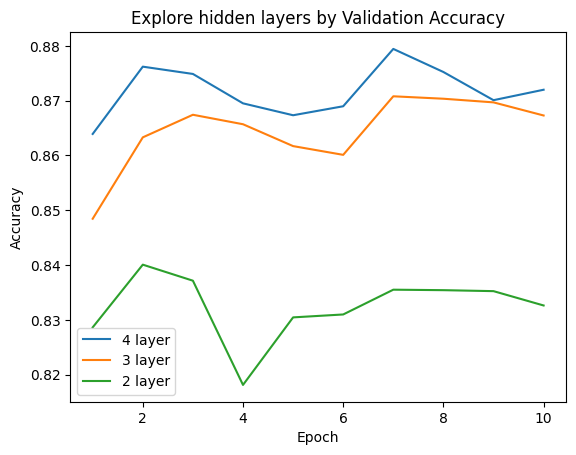



MODEL IS BETTER PERFORMING WHEN HIDDEN LAYER IS 4




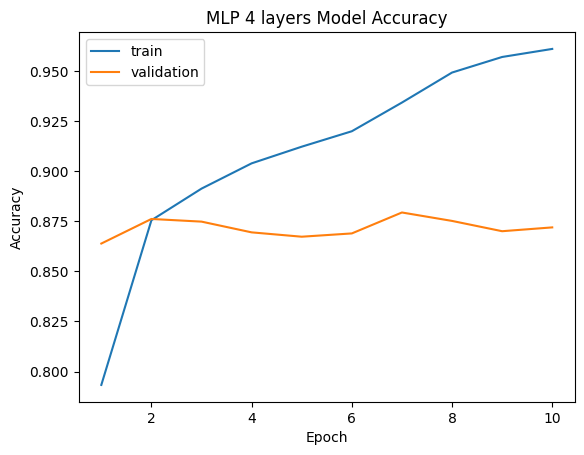

In [ ]:
#Exploring hidden layers
def create_cnn_model_4_layer():
    model = Sequential([
        Conv2D(256, kernel_size=(3,3), activation='relu', padding="same", input_shape=(28,28,1)),
        MaxPooling2D(pool_size=(2,2)),
        Conv2D(256, kernel_size=(3,3), activation='relu', padding="same"),
        MaxPooling2D(pool_size=(2,2)),
        Conv2D(128, kernel_size=(3,3), activation='relu', padding="same"),
        MaxPooling2D(pool_size=(2,2)),
        Conv2D(256, kernel_size=(3,3), activation='relu', padding="same"),
        Flatten(),
        Dense(64, activation='softmax')
    ])
    return model

def create_cnn_model_3_layer():
    model = Sequential([
        Conv2D(32, kernel_size=(3,3), activation='relu', padding="same", input_shape=(28,28,1)),
        MaxPooling2D(pool_size=(2,2)),
        Conv2D(64, kernel_size=(3,3), activation='relu', padding="same"),
        MaxPooling2D(pool_size=(2,2)),
        Conv2D(128, kernel_size=(3,3), activation='relu', padding="same"),
        Flatten(),
        Dense(64, activation='softmax')
    ])
    return model

def create_cnn_model_2_layer():
    model = Sequential([
        Conv2D(32, kernel_size=(3,3), activation='relu', padding="same", input_shape=(28,28,1)),
        Conv2D(64, kernel_size=(3,3), activation='relu', padding="same"),
        Flatten(),
        Dense(64, activation='softmax')
    ])
    return model

# Compile CNN model for each number of hidden layers
cnn_model_4_layer = create_cnn_model_4_layer()
cnn_model_3_layer = create_cnn_model_3_layer()
cnn_model_2_layer = create_cnn_model_2_layer()

cnn_model_4_layer.compile(optimizer=Adam(learning_rate = 0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
cnn_model_3_layer.compile(optimizer=Adam(learning_rate = 0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
cnn_model_2_layer.compile(optimizer=Adam(learning_rate = 0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Fit the models
print("\nFitting 4 layer model\n")
cnn_history_4_layer = cnn_model_4_layer.fit(train_data.batch(128), epochs=10, validation_data=test_data.batch(128), callbacks=[LearningRateScheduler(lr_schedule)])
print("\nFitting 3 layer model\n")
cnn_history_3_layer = cnn_model_3_layer.fit(train_data.batch(128), epochs=10, validation_data=test_data.batch(128), callbacks=[LearningRateScheduler(lr_schedule)])
print("\nFitting 2 layer model\n")
cnn_history_2_layer = cnn_model_2_layer.fit(train_data.batch(128), epochs=10, validation_data=test_data.batch(128), callbacks=[LearningRateScheduler(lr_schedule)])

# Plot CNN validation accuracy to compare hidden layers
plt.plot(range(1,11), cnn_history_4_layer.history['val_accuracy'], label='4 layer')
plt.plot(range(1,11), cnn_history_3_layer.history['val_accuracy'], label='3 layer')
plt.plot(range(1,11), cnn_history_2_layer.history['val_accuracy'], label='2 layer')
plt.title('Explore hidden layers by Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()  

print("\n\nMODEL IS BETTER PERFORMING WHEN HIDDEN LAYER IS 4\n\n")
# Plot CNN accuracy of train and validation data
plt.plot(range(1,11), cnn_history_4_layer.history['accuracy'], label='train')
plt.plot(range(1,11), cnn_history_4_layer.history['val_accuracy'], label='validation')
plt.title('CNN 4 layers Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

Number of neurons


Fitting number of neurons - 1 

Epoch 1/10
705/705 [==============================] - 36s 49ms/step - loss: 0.6324 - accuracy: 0.8025 - val_loss: 0.4107 - val_accuracy: 0.8594 - lr: 0.0010
Epoch 2/10
705/705 [==============================] - 34s 48ms/step - loss: 0.3453 - accuracy: 0.8781 - val_loss: 0.3744 - val_accuracy: 0.8715 - lr: 0.0010
Epoch 3/10
705/705 [==============================] - 34s 48ms/step - loss: 0.2766 - accuracy: 0.8974 - val_loss: 0.3838 - val_accuracy: 0.8703 - lr: 0.0010
Epoch 4/10
705/705 [==============================] - 33s 47ms/step - loss: 0.2256 - accuracy: 0.9151 - val_loss: 0.4073 - val_accuracy: 0.8702 - lr: 0.0010
Epoch 5/10
705/705 [==============================] - 33s 47ms/step - loss: 0.1880 - accuracy: 0.9262 - val_loss: 0.4439 - val_accuracy: 0.8627 - lr: 0.0010
Epoch 6/10
705/705 [==============================] - 34s 48ms/step - loss: 0.1574 - accuracy: 0.9371 - val_loss: 0.4771 - val_accuracy: 0.8628 - lr: 0.0010
Epoch 7/10
705/705 [=====

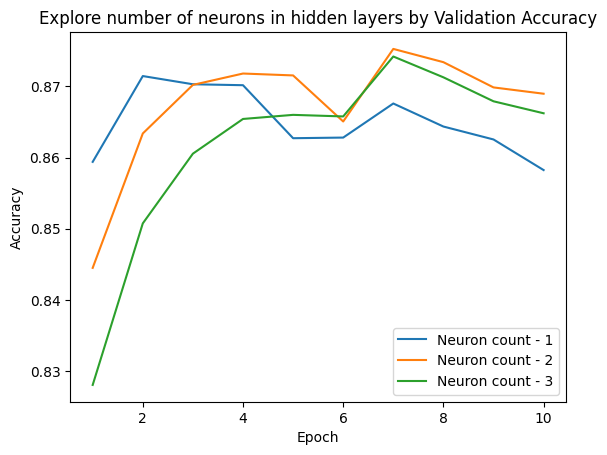



MODEL IS BETTER PERFORMING WHEN NUMBER OF NEURONS ARE 64, 64, 64




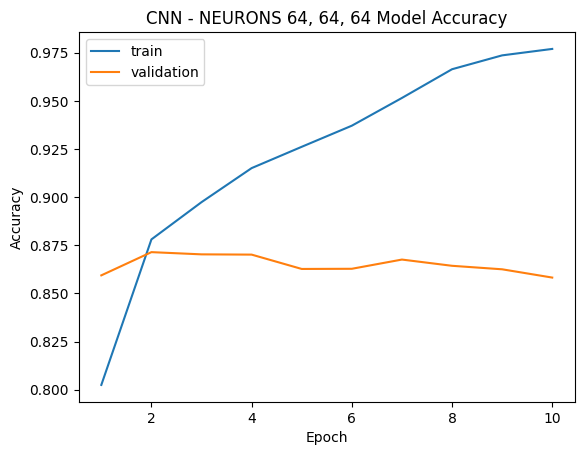

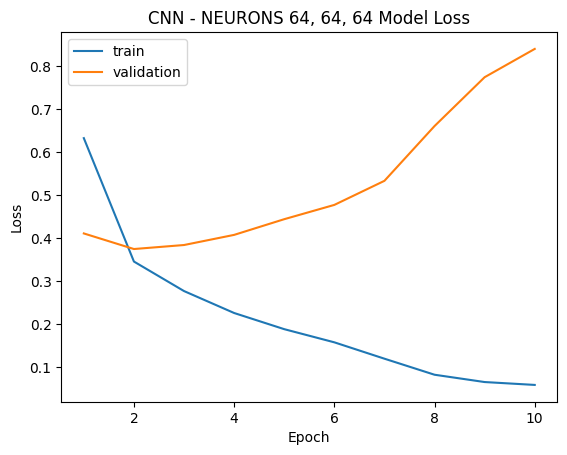

In [ ]:
# Exploring number of neurons in hidden layer

def create_cnn_model_neuron_1():
    model = Sequential([
        Conv2D(256, kernel_size=(3,3), activation='relu', input_shape=(28,28,1)),
        Conv2D(256, kernel_size=(3,3), activation='relu'),
        MaxPooling2D(pool_size=(2,2)),
        Conv2D(256, kernel_size=(3,3), activation='relu'),
        Conv2D(256, kernel_size=(3,3), activation='relu'),
        Flatten(),
        Dense(64, activation='softmax')
    ])
    return model

def create_cnn_model_neuron_2():
    model = Sequential([
        Conv2D(128, kernel_size=(3,3), activation='relu', input_shape=(28,28,1)),
        MaxPooling2D(pool_size=(2,2)),
        Conv2D(128, kernel_size=(3,3), activation='relu'),
        MaxPooling2D(pool_size=(2,2)),
        Conv2D(128, kernel_size=(3,3), activation='relu'),
        Conv2D(256, kernel_size=(3,3), activation='relu'),
        Flatten(),
        Dense(64, activation='softmax')
    ])
    return model

def create_cnn_model_neuron_3():
    model = Sequential([
        Conv2D(64, kernel_size=(3,3), activation='relu', input_shape=(28,28,1)),
        MaxPooling2D(pool_size=(2,2)),
        Conv2D(64, kernel_size=(3,3), activation='relu'),
        MaxPooling2D(pool_size=(2,2)),
        Conv2D(64, kernel_size=(3,3), activation='relu'),
        Conv2D(256, kernel_size=(3,3), activation='relu'),
        Flatten(),
        Dense(64, activation='softmax')
    ])
    return model

# Compile CNN model for each number of hidden layers
cnn_model_neuron_1 = create_cnn_model_neuron_1()
cnn_model_neuron_2 = create_cnn_model_neuron_2()
cnn_model_neuron_3 = create_cnn_model_neuron_3()

cnn_model_neuron_1.compile(optimizer=Adam(learning_rate = 0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
cnn_model_neuron_2.compile(optimizer=Adam(learning_rate = 0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
cnn_model_neuron_3.compile(optimizer=Adam(learning_rate = 0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Fit the models
print("\nFitting number of neurons - 1 \n")
cnn_history_neuron_1 = cnn_model_neuron_1.fit(train_data.batch(128), epochs=10, validation_data=test_data.batch(128), callbacks=[LearningRateScheduler(lr_schedule)])
print("\nFitting number of neurons - 2\n")
cnn_history_neuron_2 = cnn_model_neuron_2.fit(train_data.batch(128), epochs=10, validation_data=test_data.batch(128), callbacks=[LearningRateScheduler(lr_schedule)])
print("\nFitting number of neurons - 3\n")
cnn_history_neuron_3 = cnn_model_neuron_3.fit(train_data.batch(128), epochs=10, validation_data=test_data.batch(128), callbacks=[LearningRateScheduler(lr_schedule)])

# Plot CNN validation accuracy to compare number of neurons
plt.plot(range(1,11), cnn_history_neuron_1.history['val_accuracy'], label='Neuron count - 1')
plt.plot(range(1,11), cnn_history_neuron_2.history['val_accuracy'], label='Neuron count - 2')
plt.plot(range(1,11), cnn_history_neuron_3.history['val_accuracy'], label='Neuron count - 3')
plt.title('Explore number of neurons in hidden layers by Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()


print("\n\nMODEL IS BETTER PERFORMING WHEN NUMBER OF NEURONS ARE 64, 64, 64\n\n")

# Plot CNN accuracy of train and validation data
plt.plot(range(1,11), cnn_history_neuron_1.history['accuracy'], label='train')
plt.plot(range(1,11), cnn_history_neuron_1.history['val_accuracy'], label='validation')
plt.title('CNN - NEURONS 64, 64, 64 Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Plot CNN loss of train and validation data
plt.plot(range(1,11), cnn_history_neuron_1.history['loss'], label='train')
plt.plot(range(1,11), cnn_history_neuron_1.history['val_loss'], label='validation')
plt.title('CNN - NEURONS 64, 64, 64 Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

Optimizers


Fitting Adam model

Epoch 1/10
705/705 [==============================] - 8s 9ms/step - loss: 0.8019 - accuracy: 0.7582 - val_loss: 0.5126 - val_accuracy: 0.8305 - lr: 0.0010
Epoch 2/10
705/705 [==============================] - 7s 10ms/step - loss: 0.4404 - accuracy: 0.8514 - val_loss: 0.4487 - val_accuracy: 0.8469 - lr: 0.0010
Epoch 3/10
705/705 [==============================] - 7s 10ms/step - loss: 0.3636 - accuracy: 0.8745 - val_loss: 0.4299 - val_accuracy: 0.8515 - lr: 0.0010
Epoch 4/10
705/705 [==============================] - 6s 9ms/step - loss: 0.3117 - accuracy: 0.8889 - val_loss: 0.4421 - val_accuracy: 0.8509 - lr: 0.0010
Epoch 5/10
705/705 [==============================] - 7s 9ms/step - loss: 0.2679 - accuracy: 0.9031 - val_loss: 0.4720 - val_accuracy: 0.8489 - lr: 0.0010
Epoch 6/10
705/705 [==============================] - 7s 10ms/step - loss: 0.2307 - accuracy: 0.9145 - val_loss: 0.4944 - val_accuracy: 0.8484 - lr: 0.0010
Epoch 7/10
705/705 [==========================

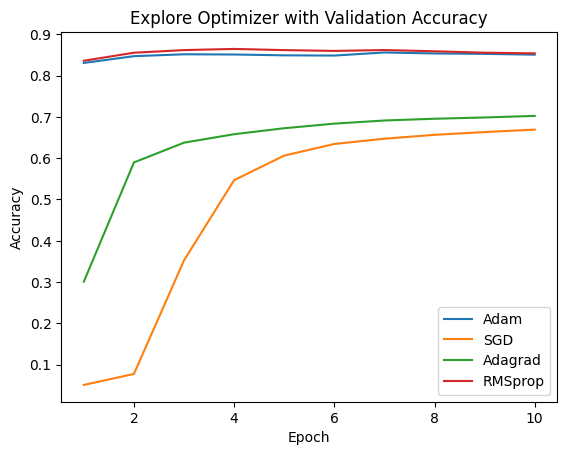

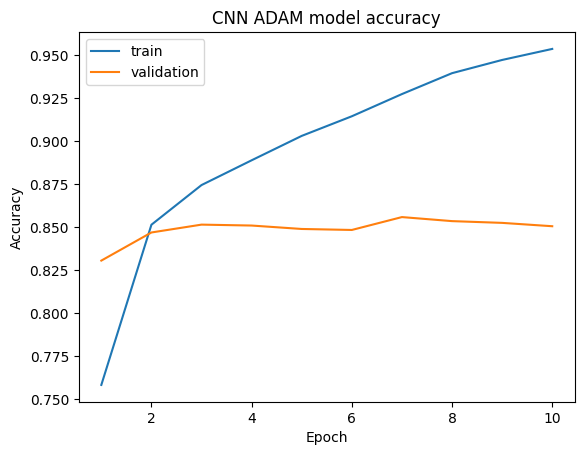

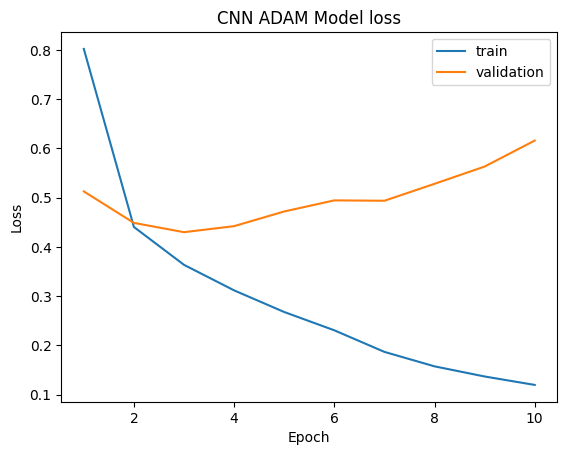

In [ ]:
# Explore types of Optimizers
# Compile CNN model for each number of hidden layers
cnn_model_Adam = create_cnn_model_relu()
cnn_model_SGD = create_cnn_model_relu() 
cnn_model_RMSprop = create_cnn_model_relu()
cnn_model_Adagrad = create_cnn_model_relu()

cnn_model_Adam.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
cnn_model_SGD.compile(optimizer=SGD(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
cnn_model_RMSprop.compile(optimizer=RMSprop(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
cnn_model_Adagrad.compile(optimizer=Adagrad(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Fit the models
print("\nFitting Adam model\n")
cnn_history_Adam = cnn_model_Adam.fit(train_data.batch(128), epochs=10, validation_data=test_data.batch(128), callbacks=[LearningRateScheduler(lr_schedule)])
print("\nFitting SGD model\n")
cnn_history_SGD = cnn_model_SGD.fit(train_data.batch(128), epochs=10, validation_data=test_data.batch(128), callbacks=[LearningRateScheduler(lr_schedule)])
print("\nFitting Adagrad model\n")
cnn_history_Adagrad = cnn_model_Adagrad.fit(train_data.batch(128), epochs=10, validation_data=test_data.batch(128), callbacks=[LearningRateScheduler(lr_schedule)])
print("\nFitting RMSprop model\n")
cnn_history_RMSprop = cnn_model_RMSprop.fit(train_data.batch(128), epochs=10, validation_data=test_data.batch(128), callbacks=[LearningRateScheduler(lr_schedule)])

# Plot CNN accuracy to compare optimiers
plt.plot(range(1,11), cnn_history_Adam.history['val_accuracy'], label='Adam')
plt.plot(range(1,11), cnn_history_SGD.history['val_accuracy'], label='SGD')
plt.plot(range(1,11), cnn_history_Adagrad.history['val_accuracy'], label='Adagrad')
plt.plot(range(1,11), cnn_history_RMSprop.history['val_accuracy'], label='RMSprop')
plt.title('Explore Optimizer with Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Plot CNN accuracy of train and test data
plt.plot(range(1,11), cnn_history_Adam.history['accuracy'], label='train')
plt.plot(range(1,11), cnn_history_Adam.history['val_accuracy'], label='validation')
plt.title('CNN ADAM model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Plot CNN loss of train and test data
plt.plot(range(1,11), cnn_history_Adam.history['loss'], label='train')
plt.plot(range(1,11), cnn_history_Adam.history['val_loss'], label='validation')
plt.title('CNN ADAM Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

Learning rate schedulers

Epoch 1/10
882/882 [==============================] - 19s 20ms/step - loss: 0.7587 - accuracy: 0.7696 - val_loss: 0.5108 - val_accuracy: 0.8366 - lr: 0.0010
Epoch 2/10
882/882 [==============================] - 8s 9ms/step - loss: 0.4156 - accuracy: 0.8599 - val_loss: 0.4433 - val_accuracy: 0.8523 - lr: 0.0010
Epoch 3/10
882/882 [==============================] - 8s 9ms/step - loss: 0.3440 - accuracy: 0.8803 - val_loss: 0.4218 - val_accuracy: 0.8568 - lr: 0.0010
Epoch 4/10
882/882 [==============================] - 8s 9ms/step - loss: 0.2956 - accuracy: 0.8950 - val_loss: 0.4227 - val_accuracy: 0.8621 - lr: 0.0010
Epoch 5/10
882/882 [==============================] - 9s 10ms/step - loss: 0.2559 - accuracy: 0.9069 - val_loss: 0.4506 - val_accuracy: 0.8574 - lr: 0.0010
Epoch 6/10
882/882 [==============================] - 9s 10ms/step - loss: 0.2213 - accuracy: 0.9166 - val_loss: 0.4968 - val_accuracy: 0.8551 - lr: 0.0010
Epoch 7/10
882/882 [==============================] - 8s 9ms/step 

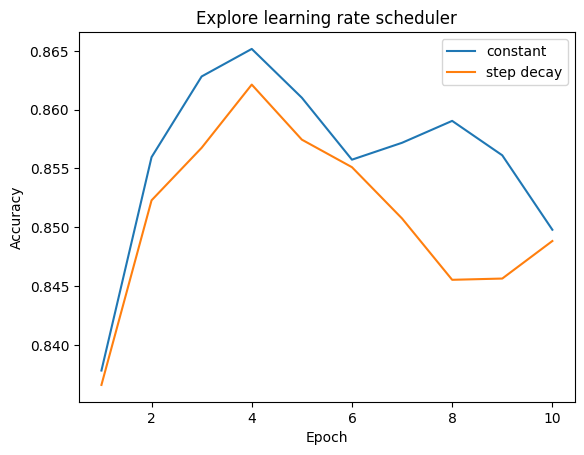



MODEL IS BETTER PERFORMING WHEN STEP DECAY LEARNING RATE SCHEDULER IS USED




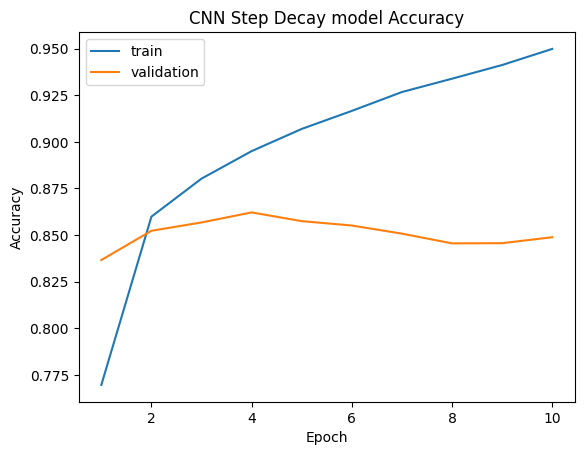

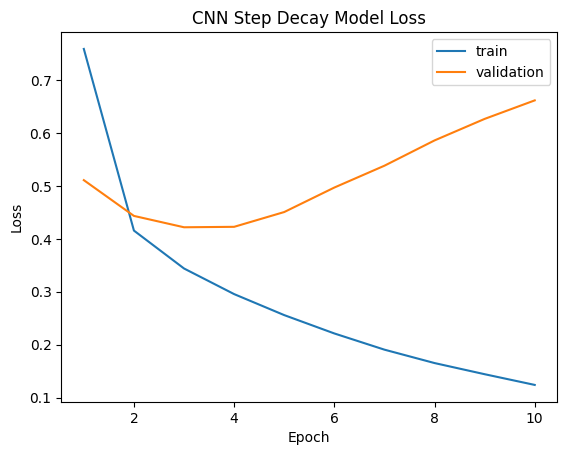

In [8]:
cnn_model_constant = create_cnn_model_relu()
cnn_model_step_decay = create_cnn_model_relu()

# Define learning rate schedule
def lr_schedule_constant(epoch):
    learning_rate = 0.001  # set a constant learning rate
    return learning_rate

def step_decay(epoch):
    initial_learning_rate = 0.001
    if epoch > 5:
       initial_learning_rate *= tf.math.exp(-0.1 * (epoch - 5))
    return initial_learning_rate

# Compile CNN model
cnn_model_step_decay.compile(optimizer = Adam(learning_rate = 0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
cnn_model_constant.compile(optimizer = Adam(learning_rate = 0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Fit CNN model
cnn_history_step_decay = cnn_model_step_decay.fit(train_data.batch(128), epochs=10, validation_data=test_data.batch(128), callbacks=[LearningRateScheduler(step_decay)])
cnn_history_constant = cnn_model_constant.fit(train_data.batch(128), epochs=10, validation_data=test_data.batch(128), callbacks=[LearningRateScheduler(lr_schedule_constant)])

# Plot CNN accuracy to explore types of learning rate schedulers
plt.plot(range(1,11),cnn_history_constant.history['val_accuracy'], label='constant')
plt.plot(range(1,11),cnn_history_step_decay.history['val_accuracy'], label='step decay')
plt.title('Explore learning rate scheduler')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

print("\n\nMODEL IS BETTER PERFORMING WHEN STEP DECAY LEARNING RATE SCHEDULER IS USED\n\n")

# Plot CNN accuracy of train and validation data
plt.plot(range(1,11),cnn_history_step_decay.history['accuracy'], label='train')
plt.plot(range(1,11),cnn_history_step_decay.history['val_accuracy'], label='validation')
plt.title('CNN Step Decay model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()
# Plot CNN loss of train and validation data
plt.plot(range(1,11),cnn_history_step_decay.history['loss'], label='train')
plt.plot(range(1,11),cnn_history_step_decay.history['val_loss'], label='validation')
plt.title('CNN Step Decay Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()


Batch Normalization 

Epoch 1/10
705/705 [==============================] - 7s 10ms/step - loss: 0.1243 - accuracy: 0.9492 - val_loss: 0.7056 - val_accuracy: 0.8446 - lr: 0.0010
Epoch 2/10
705/705 [==============================] - 6s 9ms/step - loss: 0.1143 - accuracy: 0.9538 - val_loss: 0.7731 - val_accuracy: 0.8419 - lr: 0.0010
Epoch 3/10
705/705 [==============================] - 8s 11ms/step - loss: 0.1046 - accuracy: 0.9583 - val_loss: 0.7880 - val_accuracy: 0.8441 - lr: 0.0010
Epoch 4/10
705/705 [==============================] - 6s 9ms/step - loss: 0.0962 - accuracy: 0.9612 - val_loss: 0.7923 - val_accuracy: 0.8457 - lr: 0.0010
Epoch 5/10
705/705 [==============================] - 6s 9ms/step - loss: 0.0883 - accuracy: 0.9657 - val_loss: 0.8384 - val_accuracy: 0.8428 - lr: 0.0010
Epoch 6/10
705/705 [==============================] - 7s 10ms/step - loss: 0.0801 - accuracy: 0.9681 - val_loss: 0.8827 - val_accuracy: 0.8473 - lr: 0.0010
Epoch 7/10
705/705 [==============================] - 12s 16ms/step

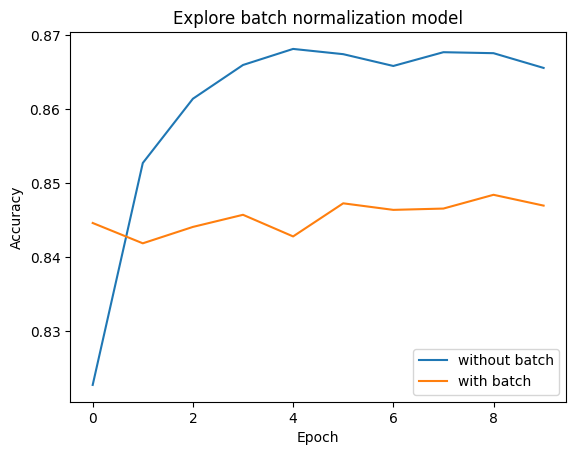

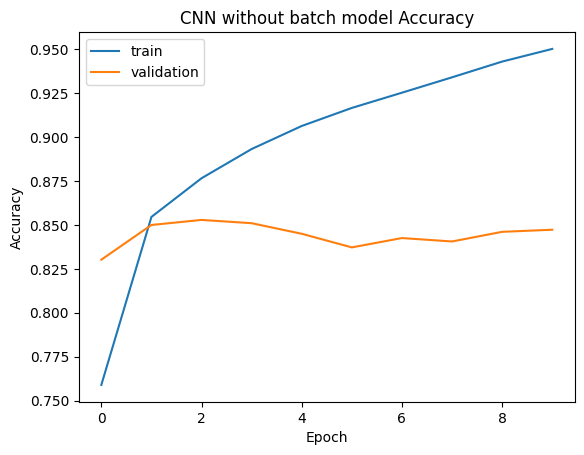

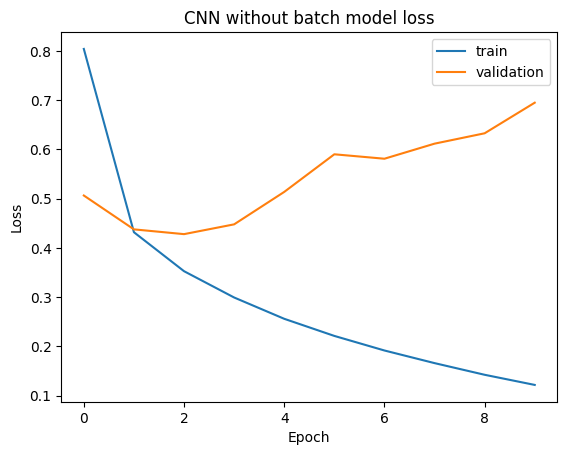

In [ ]:
# Explore batch normalization

def create_cnn_no_batch():
    model = Sequential([
        Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=(28,28,1)),
        MaxPooling2D(pool_size=(2,2)),
        Conv2D(64, kernel_size=(3,3), activation='relu'),
        MaxPooling2D(pool_size=(2,2)),
        Conv2D(128, kernel_size=(3,3), activation='relu'),
        Flatten(),
        Dense(64, activation='softmax')
    ])
    return model

def create_cnn_with_batch():
    model = Sequential([
        Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=(28,28,1)),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2,2)),
        Conv2D(64, kernel_size=(3,3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2,2)),
        Conv2D(128, kernel_size=(3,3), activation='relu'),
        BatchNormalization(),
        Flatten(),
        Dense(64, activation='softmax')
    ])
    return model

# Compile the models
cnn_model_without_batch = create_cnn_no_batch()
cnn_model_with_batch = create_cnn_with_batch()
cnn_model_without_batch.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
cnn_model_with_batch.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Fit the models
cnn_history_with_batch = cnn_model_constant.fit(train_data.batch(128), epochs=10, validation_data=test_data.batch(128), callbacks=[LearningRateScheduler(step_decay)])
cnn_history_without_batch = cnn_model_without_batch.fit(train_data.batch(128), epochs=10, validation_data=test_data.batch(128), callbacks=[LearningRateScheduler(step_decay)])

print("\n\nMODEL IS BETTER PERFORMING WITHOUT BATCH NORMALIZATION\n\n")

# Plot CNN accuracy to compare batch normalization
plt.plot(range(1,11),cnn_history_without_batch.history['val_accuracy'], label='without batch')
plt.plot(range(1,11),cnn_history_with_batch.history['val_accuracy'], label='with batch')
plt.title('Explore batch normalization model')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Plot CNN accuracy of train and validation data
plt.plot(range(1,11),cnn_history_step_decay.history['accuracy'], label='train')
plt.plot(range(1,11),cnn_history_step_decay.history['val_accuracy'], label='validation')
plt.title('CNN without batch model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()
# Plot CNN loss of train and validation data
plt.plot(range(1,11),cnn_history_step_decay.history['loss'], label='train')
plt.plot(range(1,11),cnn_history_step_decay.history['val_loss'], label='validation')
plt.title('CNN without batch model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

With L1 and L2 regularizers 

Epoch 1/10
705/705 [==============================] - 16s 21ms/step - loss: 3.1652 - accuracy: 0.4805 - val_loss: 2.0415 - val_accuracy: 0.6400 - lr: 0.0010
Epoch 2/10
705/705 [==============================] - 14s 20ms/step - loss: 1.8910 - accuracy: 0.6748 - val_loss: 1.8080 - val_accuracy: 0.6964 - lr: 0.0010
Epoch 3/10
705/705 [==============================] - 14s 20ms/step - loss: 1.7081 - accuracy: 0.7134 - val_loss: 1.6652 - val_accuracy: 0.7243 - lr: 0.0010
Epoch 4/10
705/705 [==============================] - 14s 20ms/step - loss: 1.6076 - accuracy: 0.7320 - val_loss: 1.5789 - val_accuracy: 0.7370 - lr: 0.0010
Epoch 5/10
705/705 [==============================] - 15s 22ms/step - loss: 1.5378 - accuracy: 0.7414 - val_loss: 1.5159 - val_accuracy: 0.7430 - lr: 0.0010
Epoch 6/10
705/705 [==============================] - 14s 20ms/step - loss: 1.4813 - accuracy: 0.7479 - val_loss: 1.4721 - val_accuracy: 0.7461 - lr: 0.0010
Epoch 7/10
705/705 [==============================] - 14s 

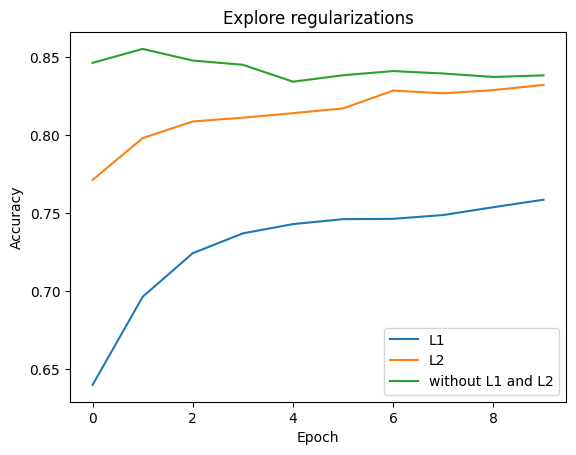

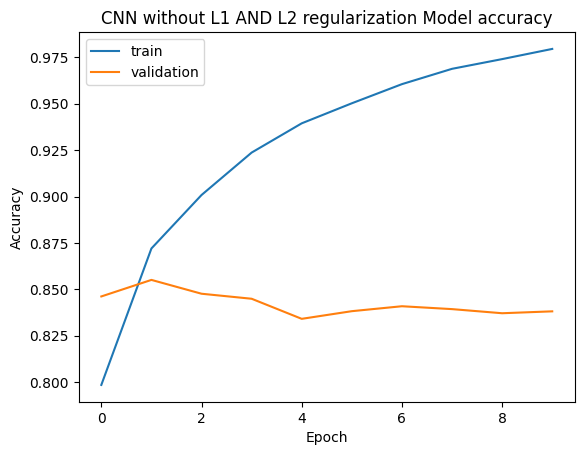

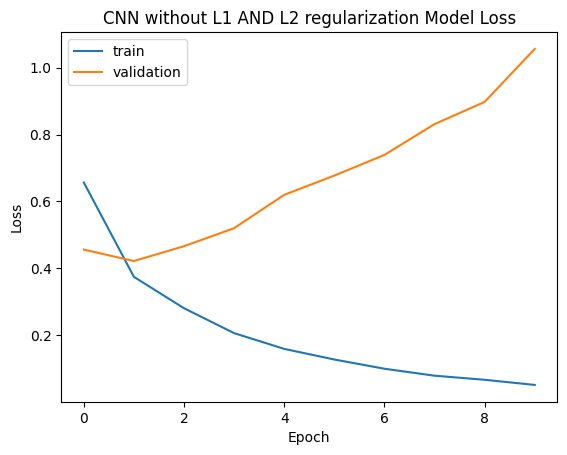

In [ ]:
# Explore L1 and L2 regularization

def create_cnn_model_l1():
    model = Sequential([
        Conv2D(256, kernel_size=(3,3), activation='relu', input_shape=(28,28,1), kernel_regularizer=regularizers.l1(0.001), bias_regularizer=regularizers.l1(0.001)),
        MaxPooling2D(pool_size=(2,2)),
        Conv2D(256, kernel_size=(3,3), activation='relu', kernel_regularizer=regularizers.l1(0.001), bias_regularizer=regularizers.l1(0.001)),
        MaxPooling2D(pool_size=(2,2)),
        Conv2D(256, kernel_size=(3,3), activation='relu', kernel_regularizer=regularizers.l1(0.001), bias_regularizer=regularizers.l1(0.001)),
        MaxPooling2D(pool_size=(2,2)),
        Flatten(),
        Dense(64, activation='softmax', kernel_regularizer=regularizers.l1(0.001), bias_regularizer=regularizers.l1(0.001))
    ])
    return model

def create_cnn_model_l2():
    model = Sequential([
        Conv2D(256, kernel_size=(3,3), activation='relu', input_shape=(28,28,1), kernel_regularizer=regularizers.l2(0.001), bias_regularizer=regularizers.l2(0.001)),
        MaxPooling2D(pool_size=(2,2)),
        Conv2D(256, kernel_size=(3,3), activation='relu', kernel_regularizer=regularizers.l2(0.001), bias_regularizer=regularizers.l2(0.001)),
        MaxPooling2D(pool_size=(2,2)),
        Conv2D(256, kernel_size=(3,3), activation='relu', kernel_regularizer=regularizers.l2(0.001), bias_regularizer=regularizers.l2(0.001)),
        MaxPooling2D(pool_size=(2,2)),
        Flatten(),
        Dense(64, activation='softmax', kernel_regularizer=regularizers.l2(0.001), bias_regularizer=regularizers.l2(0.001))
    ])
    return model

def create_cnn_model_no_l1l2():
    model = Sequential([
        Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=(28,28,1)),
        Conv2D(64, kernel_size=(3,3), activation='relu'),
        Conv2D(128, kernel_size=(3,3), activation='relu'),
        Flatten(),
        Dense(64, activation='softmax')
    ])
    return model


# Compile CNN model
cnn_model_l1 = create_cnn_model_l1()
cnn_model_l2 = create_cnn_model_l2()
cnn_model_no_l1l2 = create_cnn_model_no_l1l2()

cnn_model_l1.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
cnn_model_l2.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
cnn_model_no_l1l2.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train CNN model
cnn_history_l1 = cnn_model_l1.fit(train_data.batch(128), epochs=10, validation_data=test_data.batch(128),callbacks=[LearningRateScheduler(step_decay)])
cnn_history_l2 = cnn_model_l2.fit(train_data.batch(128), epochs=10, validation_data=test_data.batch(128),callbacks=[LearningRateScheduler(step_decay)])
cnn_history_no_l1l2 = cnn_model_no_l1l2.fit(train_data.batch(128), epochs=10, validation_data=test_data.batch(128),callbacks=[LearningRateScheduler(step_decay)])

print("\n\nMODEL IS BETTER PERFORMING WITHOUT L1 AND L2 REGULARIZATION\n\n")

# Plot CNN accuracy
plt.plot(range(1,11),cnn_history_l1.history['val_accuracy'], label='L1')
plt.plot(range(1,11),cnn_history_l2.history['val_accuracy'], label='L2')
plt.plot(range(1,11),cnn_history_no_l1l2.history['val_accuracy'], label='without L1 and L2')
plt.title('Explore regularizations')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Plot CNN accuracy of train and validation data
plt.plot(range(1,11),cnn_history_no_l1l2.history['accuracy'], label='train')
plt.plot(range(1,11),cnn_history_no_l1l2.history['val_accuracy'], label='validation')
plt.title('CNN without L1 AND L2 regularization Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Plot CNN loss of train and validation data
plt.plot(range(1,11),cnn_history_no_l1l2.history['loss'], label='train')
plt.plot(range(1,11),cnn_history_no_l1l2.history['val_loss'], label='validation')
plt.title('CNN without L1 AND L2 regularization Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()


With DropOut

Epoch 1/10
705/705 [==============================] - 13s 15ms/step - loss: 0.7176 - accuracy: 0.7781 - val_loss: 0.3964 - val_accuracy: 0.8620 - lr: 0.0010
Epoch 2/10
705/705 [==============================] - 10s 14ms/step - loss: 0.3809 - accuracy: 0.8656 - val_loss: 0.3470 - val_accuracy: 0.8766 - lr: 0.0010
Epoch 3/10
705/705 [==============================] - 10s 15ms/step - loss: 0.3260 - accuracy: 0.8814 - val_loss: 0.3352 - val_accuracy: 0.8806 - lr: 0.0010
Epoch 4/10
705/705 [==============================] - 10s 14ms/step - loss: 0.2937 - accuracy: 0.8913 - val_loss: 0.3334 - val_accuracy: 0.8808 - lr: 0.0010
Epoch 5/10
705/705 [==============================] - 10s 14ms/step - loss: 0.2697 - accuracy: 0.8979 - val_loss: 0.3445 - val_accuracy: 0.8798 - lr: 0.0010
Epoch 6/10
705/705 [==============================] - 11s 15ms/step - loss: 0.2495 - accuracy: 0.9031 - val_loss: 0.3402 - val_accuracy: 0.8803 - lr: 0.0010
Epoch 7/10
705/705 [==============================] - 10s 

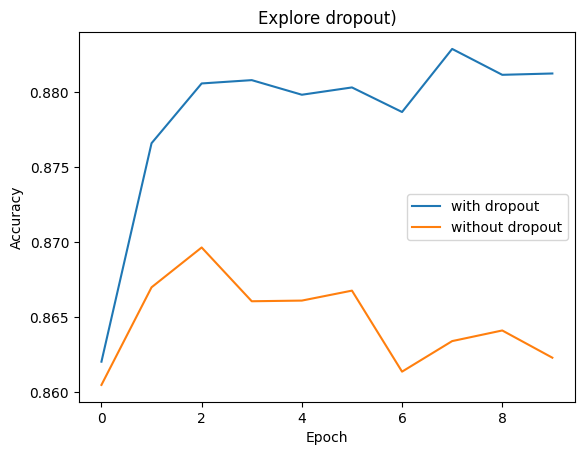

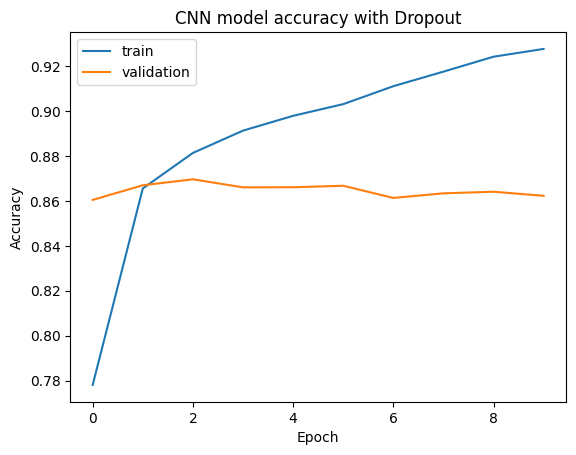

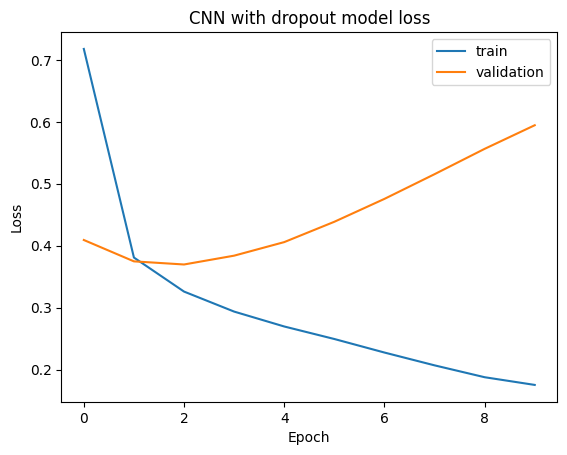

In [ ]:
def create_cnn_model_with_dropout():
    model = Sequential([
        Conv2D(32, (3,3), padding='same', input_shape=(28,28,1)),
        Activation('relu'),
        Conv2D(32, (3,3), padding='same'),
        Activation('relu'),
        MaxPooling2D(pool_size=(2,2)),
        Dropout(0.2),
        Conv2D(64, (3,3), padding='same'),
        Activation('relu'),
        Conv2D(64, (3,3), padding='same'),
        Activation('relu'),
        MaxPooling2D(pool_size=(2,2)),
        Dropout(0.2),
        Conv2D(128, (3,3), padding='same'),
        Activation('relu'),
        Flatten(),
        Dense(64, activation='softmax')
    ])
    return model

def create_cnn_model_without_dropout():
    model = Sequential([
        Conv2D(32, (3,3), padding='same'),
        Activation('relu'),
        MaxPooling2D(pool_size=(2,2)),
        Conv2D(64, (3,3), padding='same'),
        Activation('relu'),
        Conv2D(128, (3,3), padding='same'),
        Activation('relu'),
        Conv2D(128, (3,3), padding='same'),
        Activation('relu'),
        MaxPooling2D(pool_size=(2,2)),
        Flatten(),
        Dense(64, activation='softmax')
    ])
    return model

# Compile CNN model with dropout
cnn_dropout = create_cnn_model_with_dropout()
cnn_without_dropout = create_cnn_model_without_dropout()
cnn_dropout.compile(optimizer=Adam(learning_rate = 0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
cnn_without_dropout.compile(optimizer=Adam(learning_rate = 0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Fit the model
cnn_history_dropout = cnn_dropout.fit(train_data.batch(128), epochs=10, validation_data=test_data.batch(128), callbacks=[LearningRateScheduler(step_decay)])
cnn_history_without_dropout = cnn_without_dropout.fit(train_data.batch(128), epochs=10, validation_data=test_data.batch(128), callbacks=[LearningRateScheduler(step_decay)])

print("\n\nMODEL IS BETTER PERFORMING WITH DROPOUT\n\n")

# Plot CNN accuracy to compare with and without dropout
plt.plot(range(1,11),cnn_history_dropout.history['val_accuracy'], label='with dropout')
plt.plot(range(1,11),cnn_history_without_dropout.history['val_accuracy'], label='without dropout')
plt.title('Explore dropout)')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Plot CNN accuracy with dropout
plt.plot(range(1,11),cnn_history_dropout.history['accuracy'], label='train')
plt.plot(range(1,11),cnn_history_without_dropout.history['val_accuracy'], label='validation')
plt.title('CNN model accuracy with Dropout')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Plot CNN loss
plt.plot(range(1,11),cnn_history_dropout.history['loss'], label='train')
plt.plot(range(1,11),cnn_history_without_dropout.history['val_loss'], label='validation')
plt.title('CNN with dropout model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()




Implementing Final Model

Epoch 1/10
882/882 [==============================] - 18s 18ms/step - loss: 1.6855 - accuracy: 0.5093 - val_loss: 0.7971 - val_accuracy: 0.7443 - lr: 0.0010
Epoch 2/10
882/882 [==============================] - 10s 11ms/step - loss: 0.9049 - accuracy: 0.7076 - val_loss: 0.6547 - val_accuracy: 0.7852 - lr: 0.0010
Epoch 3/10
882/882 [==============================] - 9s 11ms/step - loss: 0.7829 - accuracy: 0.7446 - val_loss: 0.5888 - val_accuracy: 0.8045 - lr: 0.0010
Epoch 4/10
882/882 [==============================] - 9s 10ms/step - loss: 0.7211 - accuracy: 0.7626 - val_loss: 0.5603 - val_accuracy: 0.8132 - lr: 0.0010
Epoch 5/10
882/882 [==============================] - 9s 10ms/step - loss: 0.6827 - accuracy: 0.7739 - val_loss: 0.5363 - val_accuracy: 0.8199 - lr: 0.0010
Epoch 6/10
882/882 [==============================] - 9s 10ms/step - loss: 0.6575 - accuracy: 0.7812 - val_loss: 0.5321 - val_accuracy: 0.8223 - lr: 0.0010
Epoch 7/10
882/882 [==============================] - 9s 10ms/

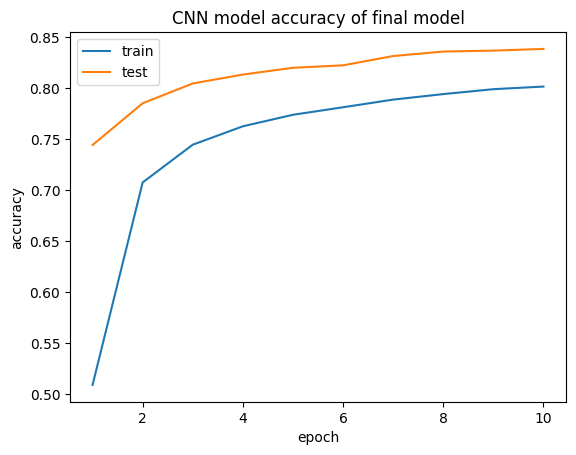

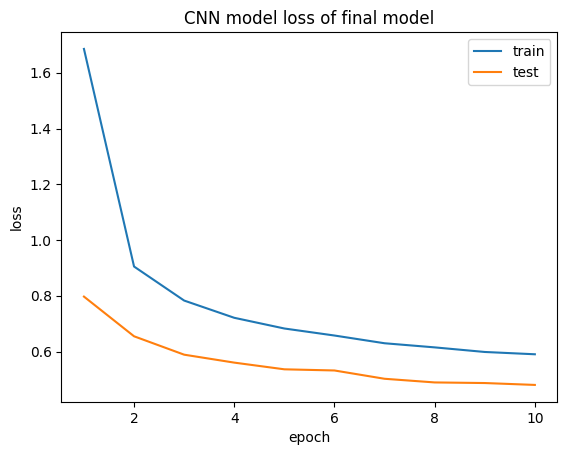




The final model performed with a test accuracy:  83.83510708808899 %
The final model performed with a test loss:  0.4802669882774353


In [9]:
def create_best_model():
    model = Sequential([
        Conv2D(64, (3,3), activation='relu', input_shape=(28, 28, 1)),
        MaxPooling2D((2,2)),
        Dropout(0.2),
        Conv2D(64, (3,3), activation='relu'),
        MaxPooling2D((2,2)),
        Dropout(0.2),
        Conv2D(64, (3,3), activation = 'relu'),
        MaxPooling2D((2,2)),
        Dropout(0.2),
        Flatten(),
        Dense(64, activation='softmax')
    ])
    return model


# Define cross-validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

train_data, test_data = tfds.load("emnist/balanced", split=["train", "test"], as_supervised=True)
train_data = train_data.map(lambda x, y: (to_image(x), y))
test_data = test_data.map(lambda x, y: (to_image(x), y))

# Compile the best model
cnn_best_model = create_best_model()
cnn_best_model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
cnn_history_best_model = cnn_best_model.fit(train_data.batch(128), epochs=10, validation_data=test_data.batch(128), callbacks=[LearningRateScheduler(step_decay)])

# Plot CNN accuracy with dropout
plt.plot(range(1,11),cnn_history_best_model.history['accuracy'], label='train')
plt.plot(range(1,11),cnn_history_best_model.history['val_accuracy'], label='test')
plt.title('CNN model accuracy of final model')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()
plt.show()

# Plot CNN loss
plt.plot(range(1,11),cnn_history_best_model.history['loss'], label='train')
plt.plot(range(1,11),cnn_history_best_model.history['val_loss'], label='test')
plt.title('CNN model loss of final model')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

print("\n\n\nThe final model performed with a test accuracy: ", 100*cnn_history_best_model.history['val_accuracy'][-1], "%")
print("The final model performed with a test loss: ", cnn_history_best_model.history['val_loss'][-1])


1/1 [==============================] - 0s 219ms/step


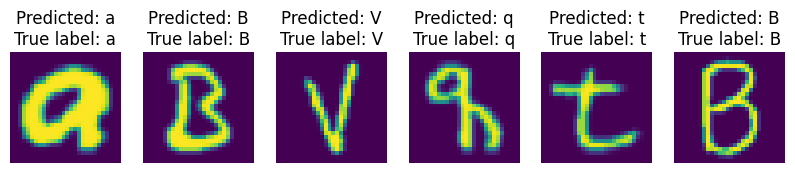

In [10]:
# 6. II. Plotting 6 test data and predicting them to match with true labels
predictions = cnn_best_model.predict(test_data.batch(6).take(1))
predicted_labels = np.argmax(predictions, axis=1)

images, true_labels = next(iter(test_data.batch(6)))
true_labels_np = true_labels.numpy()

figure = plt.figure(figsize=(10, 5))

for i in range(6):
    figure.add_subplot(1, 6, i+1)
    plt.axis("off")
    image_after_transpose = images[i].numpy().transpose((1, 2, 0))
    plt.imshow(image_after_transpose.squeeze())
    plt.title("Predicted: "+ chr(mapping_dict[predicted_labels[i]])+ "\nTrue label: "+ chr(mapping_dict[true_labels_np[i]]))

plt.show()

188/188 [==============================] - 1s 5ms/step


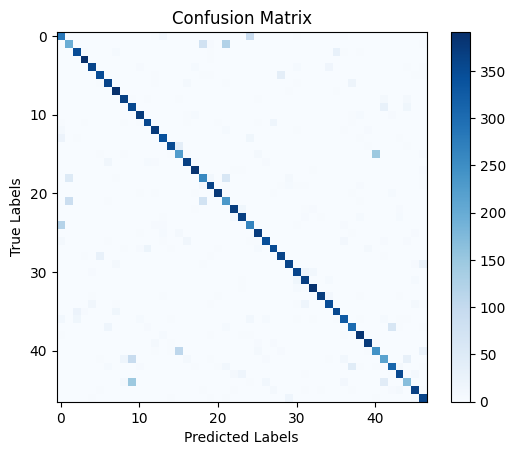

              precision    recall  f1-score   support

           0       0.61      0.71      0.66       400
           1       0.59      0.49      0.54       400
           2       0.88      0.87      0.88       400
           3       0.97      0.98      0.97       400
           4       0.94      0.90      0.92       400
           5       0.89      0.87      0.88       400
           6       0.88      0.90      0.89       400
           7       0.90      0.97      0.94       400
           8       0.91      0.92      0.91       400
           9       0.59      0.88      0.71       400
          10       0.92      0.93      0.93       400
          11       0.91      0.89      0.90       400
          12       0.91      0.93      0.92       400
          13       0.89      0.85      0.87       400
          14       0.95      0.88      0.91       400
          15       0.59      0.56      0.58       400
          16       0.90      0.92      0.91       400
          17       0.94    

In [11]:
test_dataset = test_data.batch(100)
prediction = cnn_best_model.predict(test_dataset)
y_pred = np.argmax(prediction, axis=1)

y_true = []
for x, y in test_dataset:
    y_true.append(y.numpy())
y_true = np.concatenate(y_true, axis=0)

cm = confusion_matrix(y_true, y_pred)

plt.imshow(cm, cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.colorbar()
plt.show()

# Get the classification report
class_report = classification_report(y_true, y_pred)

# Print the classification report
print(class_report)
